## Initialization (#init)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The following is a script for replicating figures and tables presented in paper "Reasoning about Regular Properties: A Comparative Study"

Run `Cell` -> `Run All` to generate files in `figs/` directory. See the `README` for more information about the context of the work.

The first cell initializes the notebook and helpers.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas
import tabulate
import pickle
import seaborn
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import csv
import re
import numpy as np
import itertools
from statistics import mean
from collections import defaultdict
from enum import Enum
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# Short hack for display of images in jupyter notebook

from IPython.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

def is_real(x):
    """Determines, whether `x` corresponds to real value"""
    try:
        float(x)
        return True
    except ValueError:
        return False        

def value_to_float(val, timeout):
    """Converts @p val to timeout or NaN"""
    if val.startswith('TO') or val == 'ERR':
        return timeout
    else:
        return np.NaN
    
def to_float_with_timeout(series, timeout):
    """Converts @p series to floats or timeouts"""
    return [float(f) if is_real(f) else value_to_float(f, timeout) for f in series]

def df_to_float(df, timeout, allow_timeouts=False):
    """Transforms @p df to dataframe with floats only, timeouts are either converted to NaN or to @p timeout"""
    return df.apply(lambda x: to_float_with_timeout(x, timeout)).dropna(how='all', axis='columns')

def unify_tool(tool):
    """Unifies the names of the tool
    
    This is due to the fact, that we tried different parameters in past and need to unify it in the data

    Add calls to `tool.replace('str', '') to remove some alternations of tools
    """
    return tool
    #return tool_to_output[tool]
        
def get_benchmark_name(bench):
    """Returns classification for @p bench benchmark"""
    if 'email_filter' in bench:
        return 'b-regex'
    elif "automata_inclusion" in bench:
        return 'b-armc-incl'
    elif 'cox' in bench:
        return 'b-param-cox'
    elif 'intersect' in bench:
        return 'b-param-intersect'
    else:
        d = os.path.dirname(bench).split(os.sep)
        return f"? {'_'.join(d[:2])}"

# Directory, where figures are stored
FIGS_DIR = "figs"
if not os.path.exists(FIGS_DIR):
    os.mkdir(FIGS_DIR)
    
def save_figure(fig, ext=".png"):
    """Stores @p fig at `figs/fig.@ext`"""
    tgt = os.path.join(FIGS_DIR, fig + ext)    
    print(f"Saving to {tgt}")
    if ext == ".png":
        plt.savefig(tgt, backend="cairo", bbox_inches="tight", pad_inches=0.2)
    else:
        plt.savefig(tgt, bbox_inches="tight", pad_inches=0.2)

Two helper dictionaries that converst the name of the tools between data -> paper -> latex

In [2]:
tool_to_latex = {
    'Automata': '\\dotnet',
    'Brics': '\\brics',
    'mata': '\\mata',
    'Mona': '\mona',
    'VATA': '\\vata',
}
tool_to_output = {
    'automata': 'Automata',
    'bricks': 'Brics',
    'mata-nfa': 'mata',
    'mona': 'Mona',
    'vata': 'VATA',
}

Helper scripts for conversion of source files to `pandas.DataFrame` format.

In [3]:
def to_pandas(src: str, timeout=60) -> pandas.DataFrame:
    """Converts @p src to pandas dataframe"""
    try:
        df = pandas.read_csv(src, delimiter=';')
    except pandas.errors.EmptyDataError:
        return pandas.DataFrame()
    columns = [
        col for col in df.columns 
        if (col == 'name' or not col.endswith('result')) # Add some other conditions
    ]
    df = df[columns]
    df['name'] = [name for name in df['name']] # add name.replace('str', '') to remove parts of benchmarks
    def rounder(x):
        if x == 'TO' or (is_real(x) and float(x) > timeout):
            return f'TO{timeout}'
        else:
            return x
    df = df.map(rounder)
    return df

def df_to_plottable(df, timeout=60):
    """Converts dataframe to a format better for certain plots"""
    columns = ['benchmark', 'file', 'tool', 'duration']
    data = []
    for index, row in df.iterrows():
        file = row['name']
        bench = get_benchmark_name(file)
        for tool, duration in [r for r in row.items() if r[0] != 'name']:
            if is_real(duration):
                data.append([bench, file, unify_tool(tool), float(duration)])
            elif duration == 'MISSING':
                continue
            else:
                data.append([bench, file, unify_tool(tool), timeout])
    return pandas.DataFrame(data, columns=columns)

List of benchmarks. Each tripplet consists of (1) benchmark name, (2) timeout, (3) source path.

Comment out benchmarks that you wish to exclude or include your own files.

In [4]:
for file in [f for f in os.listdir('data') if f.endswith('.csv')]:
    timeout = re.search("timeout-(\w+)", file).group(1)
    tag = "".join(a.capitalize() for a in itertools.takewhile(lambda x: not x[0].isdigit(), file.split('-')))
    print(f"    ('{tag}', {timeout}, os.path.join('data', '{file}')), ")

    ('BenchDoubleAutomataInclusion', 60, os.path.join('data', 'bench-double-automata-inclusion-2023-09-06-16-46-35-timeout-60-jobs-6_first-experiments.csv')), 
    ('BenchDoubleBoolCombCox', 60, os.path.join('data', 'bench-double-bool-comb-cox-2023-09-06-16-51-40-timeout-60-jobs-6_first-experiments.csv')), 
    ('BenchDoubleBoolCombCox', 60, os.path.join('data', 'bench-double-bool-comb-cox-2023-09-06-16-51-41-timeout-60-jobs-6_first-experiments.csv')), 
    ('BenchQuintupleEmailFilter', 60, os.path.join('data', 'bench-quintuple-email-filter-2023-09-06-16-54-18-timeout-60-jobs-6_first-experiments.csv')), 
    ('BenchVariadicBoolCombIntersect', 60, os.path.join('data', 'bench-variadic-bool-comb-intersect-2023-09-06-16-55-50-timeout-60-jobs-6_first-experiments.csv')), 


In [5]:
benchmarks = [
    ('BenchDoubleAutomataInclusion', 60, os.path.join('data', 'bench-double-automata-inclusion-2023-09-06-16-46-35-timeout-60-jobs-6_first-experiments.csv')), 
    ('BenchDoubleBoolCombCox', 60, os.path.join('data', 'bench-double-bool-comb-cox-2023-09-06-16-51-40-timeout-60-jobs-6_first-experiments.csv')), 
    ('BenchDoubleBoolCombCox', 60, os.path.join('data', 'bench-double-bool-comb-cox-2023-09-06-16-51-41-timeout-60-jobs-6_first-experiments.csv')), 
    ('BenchQuintupleEmailFilter', 60, os.path.join('data', 'bench-quintuple-email-filter-2023-09-06-16-54-18-timeout-60-jobs-6_first-experiments.csv')), 
    ('BenchVariadicBoolCombIntersect', 60, os.path.join('data', 'bench-variadic-bool-comb-intersect-2023-09-06-16-55-50-timeout-60-jobs-6_first-experiments.csv')), 
]

## Input dataframe (#dataframe)

Creates three dataframes:
  1. `dataframe_map` maps benchmark to its dataframe (created by `to_pandas()`)
  2. `plottable_map_per_grp` maps benchmarks to its plottable dataframe (created by `df_to_plottable()`)
  3. `overall_df` consists of all dataframes from `dataframe_map` merged into a single dataframe.

In [6]:
dataframe_map = {}
plottable_map_per_grp = {}

for bench, timeout, src in benchmarks:
    key = f"{bench}#{timeout}"
    df = to_pandas(src, timeout=timeout)
    dataframe_map[key] = df
    plottable_map_per_grp[key] = df_to_plottable(df, timeout=timeout)
    
overall_df = pandas.concat([df for key, df in dataframe_map.items()])

Specification of color map further used in figures.

In [7]:
tools = sorted([unify_tool(t) for t in overall_df.columns if t != 'name' and t != 'bench'])
tool_len = len(tools)
color_map = {
    t: c for (t, c) in zip(tools, mpl.colormaps['tab20'].resampled(tool_len).colors)
}

## Summary of statistics (#stats)

For two sets of data (`afa` and `bre` benchmarks) creates (1) a HTML table, and (2) LaTeX table.
Each table summaries the data for each benchmark and tool, each cell contains tripplets of mean, median and number of timeouts. Timeouts include errors and out of memories.

If you wish to plot means and timeouts only, change the following line:
```python
cols = 2
```

In [8]:
cols = 3
engine = 'text' # change to 'latex_raw' to output different
ext = 'tex' if engine == 'latex_raw' else 'txt'
sep = " & " if engine == 'latex_raw' else '|'

def count_short_stats(series):
    """For @p series counts either tripple (mean, median, timeouts) or (mean, timeouts)"""
    global cols
    vals = [float(v) if is_real(v) else value_to_float(v, 60) for v in series] or [-1]
    if cols == 3:
        to_len = len([s for s in series if str(s).startswith('TO')])
        err_len = len([s for s in series if str(s).startswith('ERR')])
        return (
            round(np.nanmean(vals), 1), 
            round(np.nanmedian(vals), 1), 
            f"{to_len}" if err_len == 0 else f"{to_len}({err_len})"
        )
    else:
        return (round(np.nanmean(vals), 1), len([s for s in series if str(s).startswith('TO')]))

def to_multicol(value, size=cols):
    return f'\\multicolumn{{{size}}}{{c|}}{{{value}}}' if engine == 'latex_raw' else value

def to_cell(stats, n):
    """Transforms @p n -th statistic stored in @p stats into a cell"""
    cell = stats.get(n, '-')
    if cell == '-' or (np.isnan(cell[0]) and (cell[-1] == 0 or cell[-1] == '0')):
        return to_multicol('-')
    else:
        return sep.join(str(c) for c in cell[:cols])
        
# Groups dataframes by benchmarks, and computs shorts stats for each benchmark and tool.
grp_df = overall_df.copy()
grp_df['benchmark'] = [get_benchmark_name(b) for b in grp_df['name']]
grp_df = grp_df[[c for c in grp_df.columns if c != 'name']]
b_param = 'b-param'
benchmark_names = sorted(list(set(grp_df['benchmark'])))
benchmark_names = [b for b in benchmark_names if b != b_param] + ([b_param] if b_param in benchmark_names else [])
headers = ['tool'] + [to_multicol(b) for b in benchmark_names]
data = []

grp_items = grp_df.groupby('benchmark').agg(count_short_stats).items()
for group in grp_items:
    if group[0] == 'bench':
        continue
    #tool = tool_to_latex[unify_tool(group[0])]
    tool = unify_tool(group[0])
    stats = group[1].to_dict()
    data.append([tool] + [to_cell(stats, n) for n in benchmark_names])
data = sorted(data, key=lambda x: x[0])
# Creates a splice for BRE benchmarks; note that the indexes are fixed wrt ordering of the benchmarks
dheaders = ['tool'] + headers[1:]
ddata = [[d[0]] + d[1:] for d in data]
with open(os.path.join('figs', 'stats.html'), 'w') as stats_handle:
    stats_handle.write(tabulate.tabulate(ddata, headers=dheaders, tablefmt='html'))
with open(os.path.join('figs', f'stats{"-mean-only" if cols == 2 else ""}.{ext}'), 'w') as stats_handle:
    stats_handle.write("\n".join(tabulate.tabulate(ddata, headers=dheaders, tablefmt=engine).split("\n")[2:-1]))
print(tabulate.tabulate(ddata, headers=dheaders))

tool                               b-armc-incl     b-param-cox    b-param-intersect    b-regex
---------------------------------  --------------  -------------  -------------------  ---------
automata-runtime                   20.6|0.7|4(41)  3.2|2.1|0      50.2|60.0|154(1)     0.2|0.2|0
mata-automata_inclusion_antichain  0.1|0.0|0       -              -                    0.0|0.0|0
mata-automata_inclusion_naive      1.5|0.0|0       -              -                    0.0|0.0|0
mata-emptiness_check               -               5.8|3.9|0      -                    -
mata-intersection_emptiness        -               -              49.4|60.0|0(122)     -
mata-mintermization                0.1|0.1|0       0.0|0.0|0      39.7|60.0|0(122)     0.0|0.0|0
mata-parsing                       7.4|4.5|0       1.5|1.3|0      39.6|60.0|0(122)     0.3|0.2|0
mata-runtime                       10.6|6.7|7      7.3|5.3|0      51.6|60.0|38(122)    0.8|0.2|4


/tmp/ipykernel_63205/3388522642.py:14: RuntimeWarning: Mean of empty slice
  round(np.nanmean(vals), 1),
/tmp/ipykernel_63205/3388522642.py:15: RuntimeWarning: All-NaN slice encountered
  round(np.nanmedian(vals), 1),


## Lineplot (#line)
The following plots cummulative graph of times. For each tool, it prints how long it took to process the benchmarks, if ordered by runtime. Continuous timeouts are omitted.

In [9]:
def sum_generator(series, timeout):
    """Cumulatively sums the @p series wrt @p timeout"""
    sum = 0
    for num in series:
        if num >= timeout:
            yield None
        else:
            sum += num
            yield sum

Saving to figs/cactus.png
Saving to figs/cactus.pdf


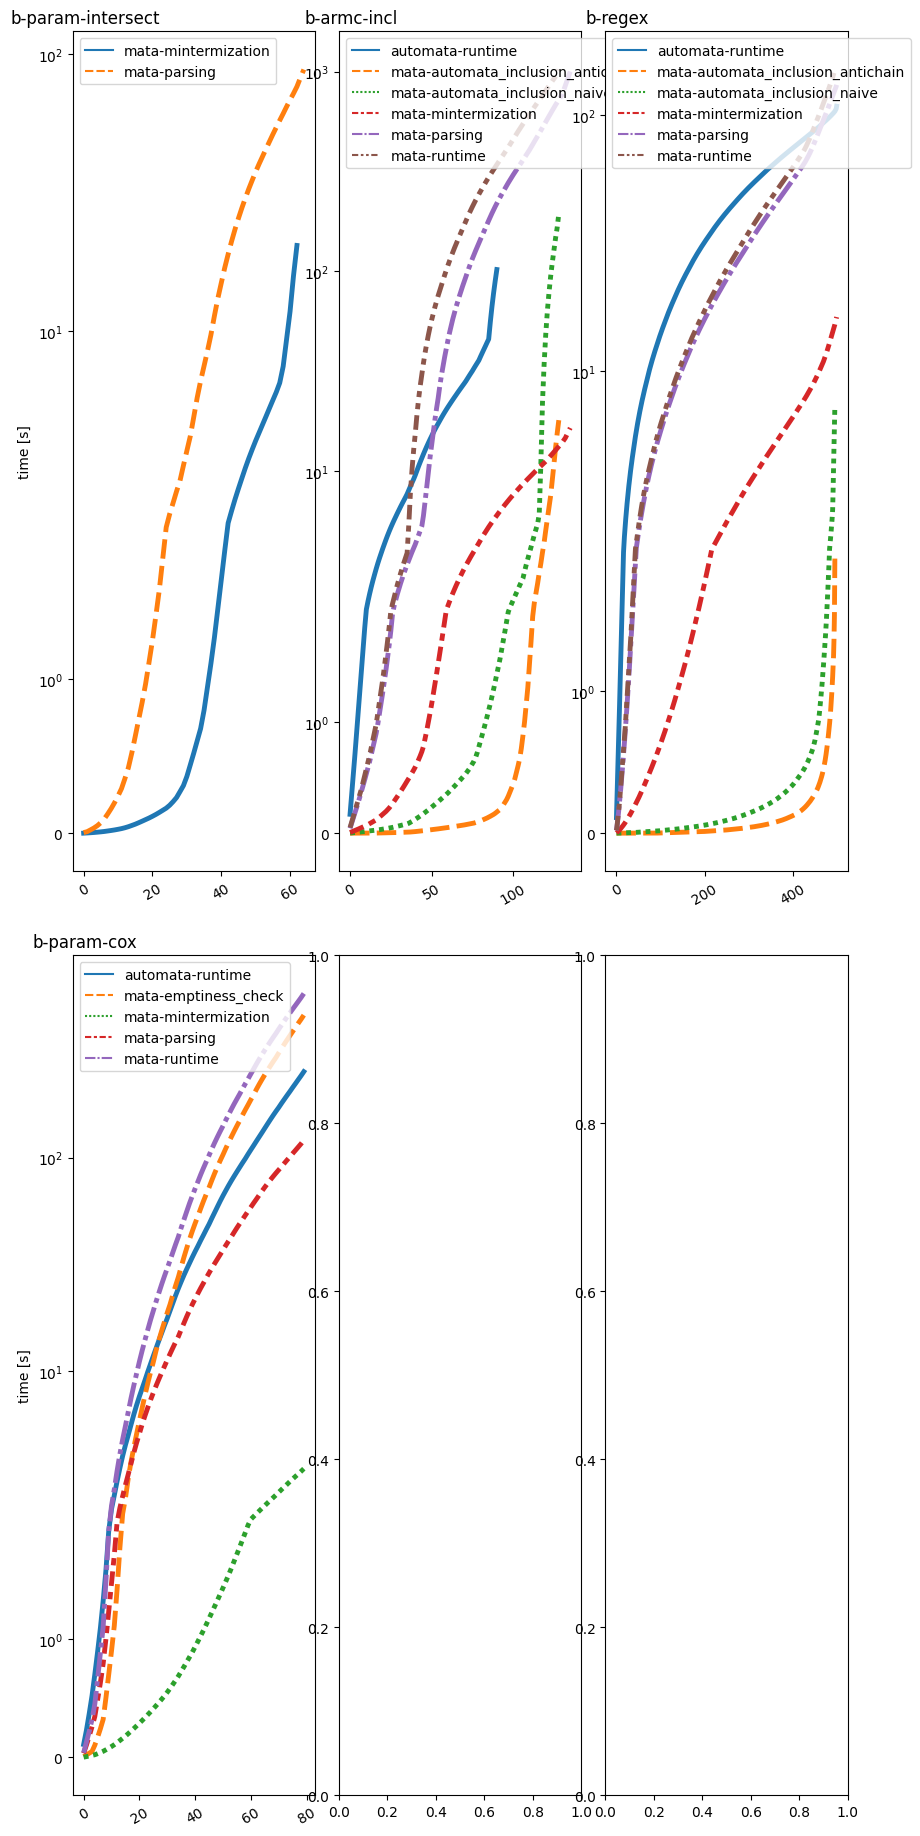

In [10]:
BEST_RATE = 0.2

item_no = len(plottable_map_per_grp.items())

x_dim = item_no // 3 + 1
y_dim = min(item_no, 3)
fig, ax = plt.subplots(x_dim, y_dim, figsize=(x_dim*5, y_dim*6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.1)
bench_list = [
    'b-param-intersect', 'b-armc-incl', 'b-regex', 'b-param-cox'                        # BRE Benchmarks
]

for key, pdf in plottable_map_per_grp.items():
    bench, timeout = key.split('#')
    timeout = int(timeout)
    subgroups = set(list(pdf['benchmark']))
    for grp in subgroups:
        data = pdf[pdf['benchmark'] == grp]
        # Parametric benchmarks will be visualized in other way.
        if grp.endswith('-param'):
            continue
        i = bench_list.index(grp)
        sums = defaultdict(list)
        grp_name = f"{grp}"

        # Preprocesses the data to cumulative suns. Filters out those that did not solve
        # at least 20% of benchmarks in given groups
        for _, row in data.iterrows():
            sums[row['tool']].append(row['duration'])
        vdata = {}
        for k in sorted(sums.keys()):
            v = sums[k]
            values = list(sum_generator(sorted(v), timeout))
            val_len = len(values)
            to_len = len([a for a in values if a == None])
            if (val_len - to_len) / val_len > BEST_RATE:
                vdata[k] = values
                
        # Plot is in logarithmic scale
        g = seaborn.lineplot(
            vdata, linewidth=3.5, ax=ax[i // 3, i % 3] if item_no > 1 else ax
        )
        g.set(yscale="symlog")
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        g.set_title(f"{grp_name}", x=0.05)    
        if i % 3 == 0:
            g.set_ylabel("time [s]")
        if i // 3 == 2:
            g.set_xlabel("benchmark")
        seaborn.move_legend(g, "upper left", bbox_to_anchor=(0., 1), frameon=True)
        i += 1

# Saves figures into `figs/` directory
save_figure(f"cactus")
save_figure(f"cactus", ext=".pdf")

## Infering Parametric models

For two benchmarks `a-param` and `b-param` we created individual models, that models runtime (on `y` axis) based on the value of parameter `k`. Refer to our paper or main site to learn more about the individual families.

In [11]:
columns = ['bench', 'k', 'tool', 'duration']
parametric = ['intersect', 'cox']
number_matcher = re.compile("\d+")
def to_models(df):
    """Computes models out of @p df"""
    data = []
    for index, row in df.iterrows():
        if not any(p in row['name'] for p in parametric):
            continue
        bench_name = os.path.split(row['name'])[-1]
        bench = bench_name.split('-')[0]
        k = number_matcher.findall(bench_name)[-1]
        if is_real(k):
            k = int(k)
            for col, v in row.items():
                if col == 'name':
                    continue
                tool = unify_tool(col)
                if v == 'ERR':
                    time = np.NaN
                elif is_real(v):
                    time = float(v)
                elif v.startswith('TO'):
                    time = int(v[2:])
                else:
                    continue
                data.append([bench, k, tool, time])
    tmp_data = sorted(data, key=lambda x: x[1])
    to_map = defaultdict(list)
    data = []
    for val in tmp_data:
        key = f"{val[0]}:{val[2]}"
        if val[-1] >= 60:
            # it's timeout:
            if not to_map[key] or to_map[key][-1] < 60:
                data.append(val)
        else:
            data.append(val) 
        to_map[key].append(val[-1])
    models = pandas.DataFrame(data, columns=columns)
    return models
for key, df in dataframe_map.items():
    models = to_models(df)

Saving to figs/models.png
Saving to figs/models.pdf


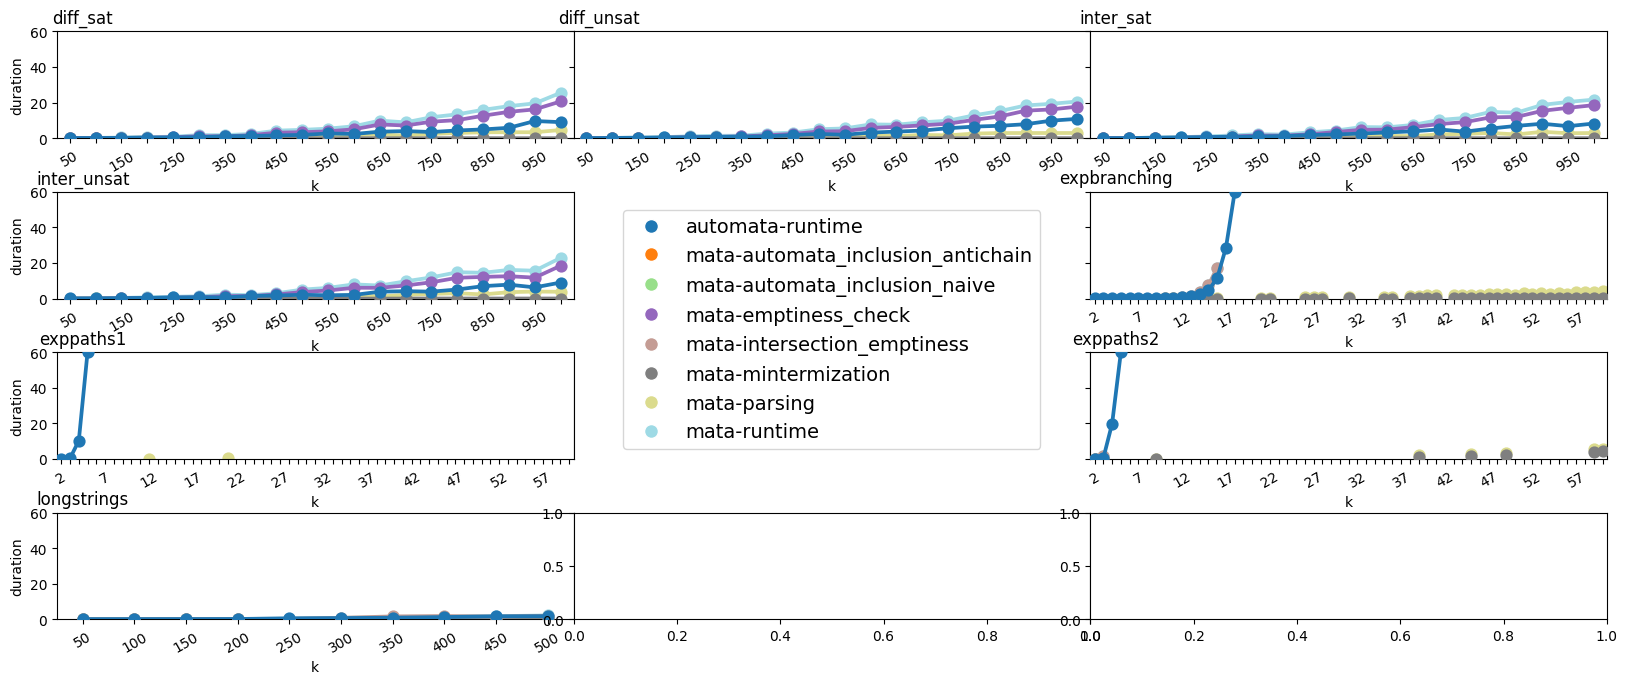

In [12]:
# Mapping of measured benchmarks to names use in paper
bench_to_paper = {
    'longstrings': 'longstrings',
    'expbranching': 'expbranching',
    'exppaths1': "exppaths1",
    'exppaths2': "exppaths2",
    'diff_sat': "diff_sat",
    'diff_unsat': "diff_unsat",
    'inter_sat': "inter_sat",
    'inter_unsat': "inter_unsat",
}


f, axs = plt.subplots(4, 3, figsize=(20, 6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.0)
i = 0
for key in sorted(dataframe_map.keys()):
    df = dataframe_map[key]
    models = to_models(df)
    for bench in sorted(set(models['bench'])):
        # The following model is skipped as it is not that interesting
        if bench in ('ltl_afa/created_ltl/LTLf-specific',):
            continue
        data_df = models[models['bench'] == bench]
        g = seaborn.pointplot(
            data_df, x="k", y="duration", hue="tool", errorbar=None, 
            ax=axs[i // 3, i % 3], palette=color_map, markers='o',
        )
        g.legend([],[], frameon=False)
        g.set_ylim([0, 60])
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        tick_rate = len(g.get_xticklabels()) // 10
        if tick_rate != 0:
            for index, label in enumerate(g.get_xticklabels()):
                if index % tick_rate == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)
        g.set_title(f"{bench_to_paper[bench]}", x=0.05)
        if i % 3 != 0:
            g.set(yticklabels=[])
            g.set(ylabel=None)
        seaborn.move_legend(g, "upper right", bbox_to_anchor=(1, 1), ncols=2)
        # The following are some black magic hacks have the final layout
        i += 1
        if i == 4 or i == 7:
            i += 1
# The following are some black magic hacks have the final layout
i = 4
axs[i // 3, i % 3].set(xlabel=None)
axs[i // 3, i % 3].set(yticklabels=[])
axs[i // 3, i % 3].set(xticklabels=[])
axs[i // 3, i % 3].set(xticks=[])
axs[i // 3, i % 3].set(yticks=[])
axs[i // 3, i % 3].spines['top'].set_visible(False)
axs[i // 3, i % 3].spines['bottom'].set_visible(False)

# The following are some black magic hacks to print the label in the middle
i = 7
axs[i // 3, i % 3].legend(
    handles=[
        Line2D(
            [0], [0], color='w', marker='o', markerfacecolor=color_map[tool], label=f"{tool}", 
            markersize=10,
        )
        for tool in sorted(color_map.keys())
    ], ncols=1, loc='lower center', fontsize='14'
)
axs[i // 3, i % 3].set(xlabel=None)
axs[i // 3, i % 3].set(yticklabels=[])
axs[i // 3, i % 3].set(xticklabels=[])
axs[i // 3, i % 3].set(xticks=[])
axs[i // 3, i % 3].set(yticks=[])
axs[i // 3, i % 3].spines['top'].set_visible(False)
axs[i // 3, i % 3].spines['bottom'].set_visible(False)
save_figure(f'models')
save_figure(f'models', ext='.pdf')

## Scatter plot of winners

For each benchmark we picked three winners and compared each other in scatter plot.

Saving to figs/scatter.png
Saving to figs/scatter.pdf


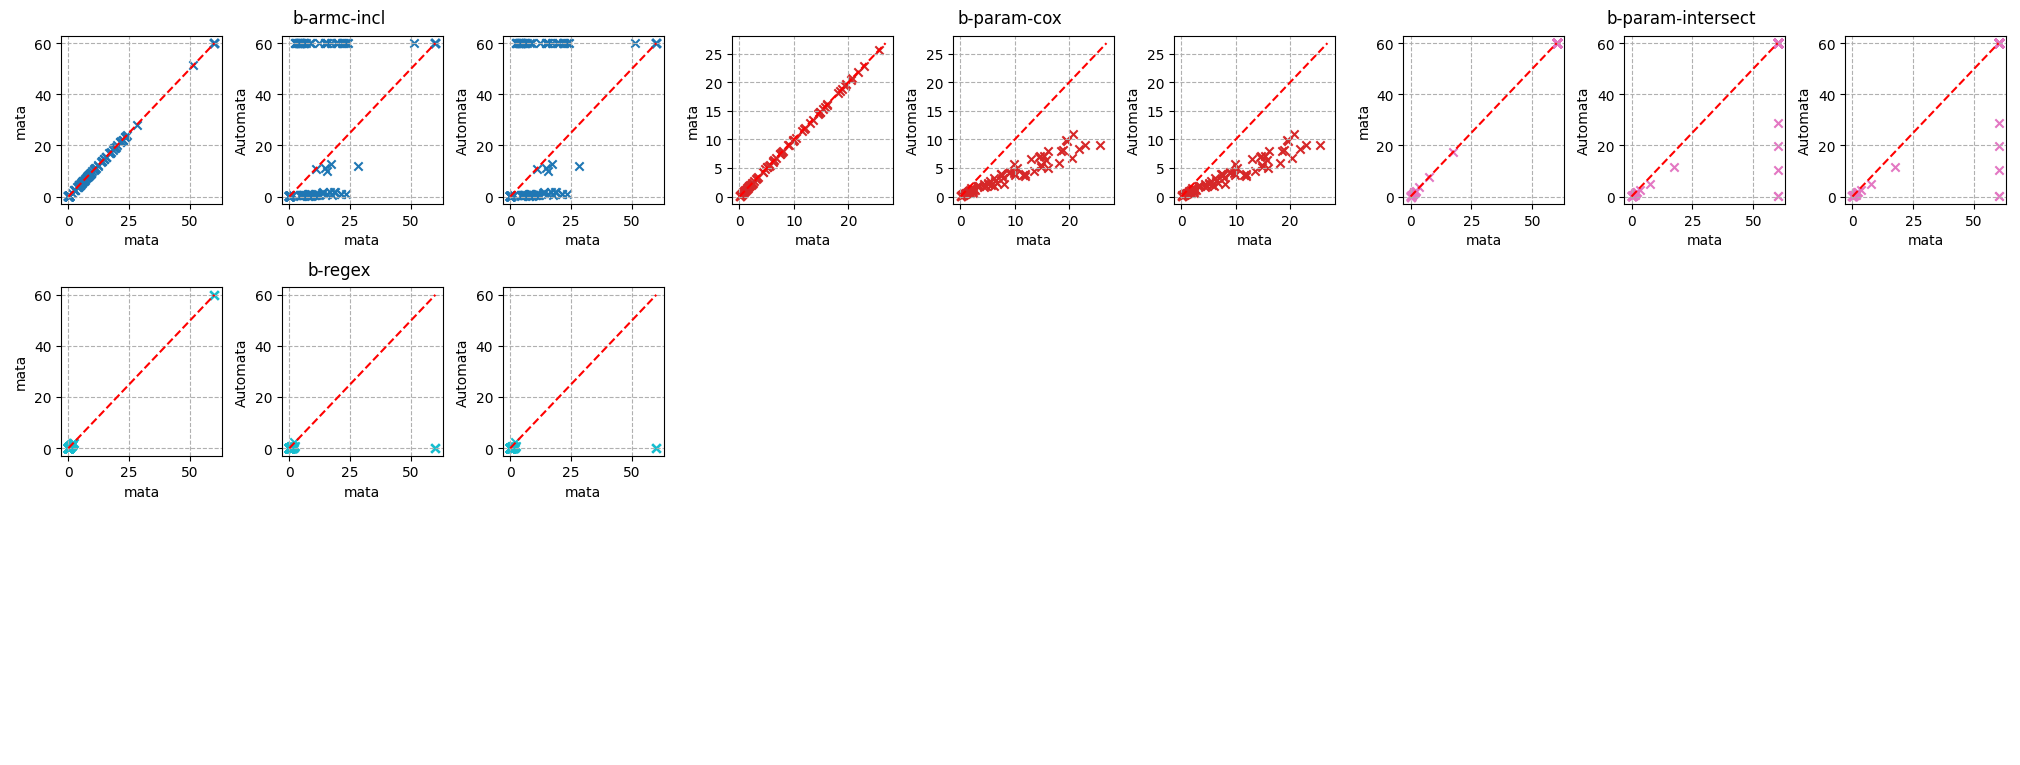

In [13]:
# TO
overall_df['bench'] = [get_benchmark_name(n) for n in overall_df['name']]
benches = sorted([b for b in sorted(list(set(overall_df['bench']))) if not b.endswith('-param')])

winners = {
    'b-armc-incl': ['mata', 'mata', 'automata'], 
    'b-param-cox': ['mata', 'mata', 'automata'],
    'b-param-intersect': ['mata', 'mata', 'automata'],
    'b-regex': ['mata', 'mata', 'automata'], 
}
indices = [(1, 2), (1, 3), (2, 3)]
bench_colors = mpl.colormaps['tab10'].resampled(len(benches)).colors
fig = plt.figure(constrained_layout=True, figsize=(4*5, 3*2.5))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.3)
subfigs = fig.subfigures(3, 3)
for i, subfig in enumerate(subfigs.flat):
    if i == len(benches):
        break
    subfig.suptitle(f"{benches[i]}")
    axs = subfig.subplots(1, 3)
    bench = benches[i]
    bench_df = df_to_float(overall_df[overall_df['bench'] == bench], 60, allow_timeouts=True)
    for ii, ax in enumerate(axs.flat):
        lhs, rhs = indices[ii]
        lhs, rhs = winners[bench][lhs-1], winners[bench][rhs-1]
        ax.grid(True, which='both', linestyle='--')
        ax.set_xlabel(f"{tool_to_output.get(lhs, lhs)}")
        ax.set_ylabel(f"{tool_to_output.get(rhs, rhs)}")
        ax.scatter(
            bench_df[f"{lhs}-runtime"], bench_df[f"{rhs}-runtime"], marker= 'x', c=[bench_colors[i]]
        )
        pt = min(max(ax.get_xlim()[1], ax.get_ylim()[1]), 60)
        ax.plot([0, pt], [0, pt], linestyle='--', color='red')
save_figure("scatter")
save_figure("scatter", ext=".pdf")
plt.show()

In [14]:
print("Processing experiments complete")

Processing experiments complete
